## Задание

### Часть 1 (5 балла)
1. Выберите одну любую из задач, рассмотренных на [лекции](https://colab.research.google.com/drive/1B7Np_7y002NLiuNkriq6a6MchQL4Fw7p?usp=sharing) (локализация, сегментация, перенос стиля, генерация).

2. Подберите на kaggle датасет, подходящий для решения этой задачи.
  - Вариант 1: если данные обладают необходимой разметкой, то повторите пайплайн из блокнота с примером на своих данных.
  - Вариант 2: если данные не обладают необходимой разметкой, то используйте модель, которую дообучали в примере, но без дообучения.
3. Оцените и прокомментируйте результат.

### Часть 2 (8 баллов)
1. Выберите еще одну из рассмотренных в лекции задач (не совпадающую с первой).
2. Если ваши данные обладают разметкой, необходимой для новой задачи, продолжите работу с ними. Если нет, найдите другой датасет, в котором она будет. Можно взять какой-нибудь стандартный в PyTorch, но такой, который не встречался ни в одном из примеров с лекции. В этом задании обязательно нужно найти датасет с разметкой.
3. Повторите пайплайн из примера.
4. Постарайтесь улучшить качество результата (если классификация - точность выше 90%, во всех остальных - максимально понизить лосс). Это можно сделать за счет настройки гиперпараметров. Можно (опционально и в зависимости от задачи) также поменять гиперпараметры в слоях нейронных сетей и/или порядок слоев и/или их количество.

В заданиях, где перечислены два варианта выполнения, нужно выбрать только один. Выполнение обоих дополнительных баллов не дает.



# Часть 1

Выполняем **сегментацию**

Возьмем датасет с машинами 🏎️ и попробуем отделить их на изображении.

https://www.kaggle.com/datasets/intelecai/car-segmentation

In [ ]:
import os
import cv2
import torch
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

path = kagglehub.dataset_download("intelecai/car-segmentation")
print("Path to dataset files:", path)

images_dir = os.path.join(path, "car-segmentation", "images")
masks_dir = os.path.join(path, "car-segmentation", "masks")

Path to dataset files: /root/.cache/kagglehub/datasets/intelecai/car-segmentation/versions/2


In [ ]:
image_files = sorted(glob.glob(os.path.join(images_dir, "*.png")))
mask_files = sorted(glob.glob(os.path.join(masks_dir, "*.png")))

assert len(image_files) == len(mask_files), "Количество изображений и масок не совпадает!"

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_list, masks_list, transforms=None):
        """
        images_list: список путей к изображениям
        masks_list: список путей к маскам
        transforms: аугментации и нормализация
        """
        self.images = images_list
        self.masks = masks_list
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)  # преобразоваение в бинарную

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, torch.tensor(mask, dtype=torch.float32).unsqueeze(0)


Аугментации для обучения и тестирования

In [ ]:
train_transforms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Для EfficientNet
    ToTensorV2(),
])

In [ ]:
test_transforms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

In [ ]:
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)


In [ ]:
train_dataset = SegmentationDataset(train_images, train_masks, transforms=train_transforms)
test_dataset = SegmentationDataset(test_images, test_masks, transforms=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
import torch.nn as nn
import segmentation_models_pytorch as smp

class SegmentationModel(nn.Module):
  def __init__(self, encoder="timm-efficientnet-b0", weights="imagenet"):
    super(SegmentationModel, self).__init__()

    self.architecture = smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.architecture(images)

    if masks is not None:
      loss1 = DiceLoss(mode="binary")(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = smp.Unet(
    encoder_name="timm-efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

lr = 1e-4

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 85.6MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #dlya otladki
model = model.to(device)

print(device)

cuda


In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

In [ ]:
num_epochs = 20
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

torch.save(model.state_dict(), "unet_efficientnet_b0.pth")

<ipython-input-20-3cbb1416ec08>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.float32).unsqueeze(0)


Epoch 1/20, Train Loss: 0.6081126758030483, Val Loss: 0.4544965326786041
Epoch 2/20, Train Loss: 0.3866554413522993, Val Loss: 0.2579330975810687
Epoch 3/20, Train Loss: 0.25156934559345245, Val Loss: 0.20020408928394318
Epoch 4/20, Train Loss: 0.17956055204073587, Val Loss: 0.1457300583521525
Epoch 5/20, Train Loss: 0.14192824491432735, Val Loss: 0.13713768248756728
Epoch 6/20, Train Loss: 0.1217318553300131, Val Loss: 0.10766395429770152
Epoch 7/20, Train Loss: 0.10360038919108254, Val Loss: 0.10030568018555641
Epoch 8/20, Train Loss: 0.09263549886998676, Val Loss: 0.09241324414809544
Epoch 9/20, Train Loss: 0.08578963364873614, Val Loss: 0.08387784163157146
Epoch 10/20, Train Loss: 0.07908297933283306, Val Loss: 0.08116690814495087
Epoch 11/20, Train Loss: 0.07132546834292866, Val Loss: 0.07502902299165726
Epoch 12/20, Train Loss: 0.07087999937080201, Val Loss: 0.07275675050914288
Epoch 13/20, Train Loss: 0.06617856345006398, Val Loss: 0.06716279809673627
Epoch 14/20, Train Loss: 0.

<ipython-input-20-3cbb1416ec08>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.float32).unsqueeze(0)


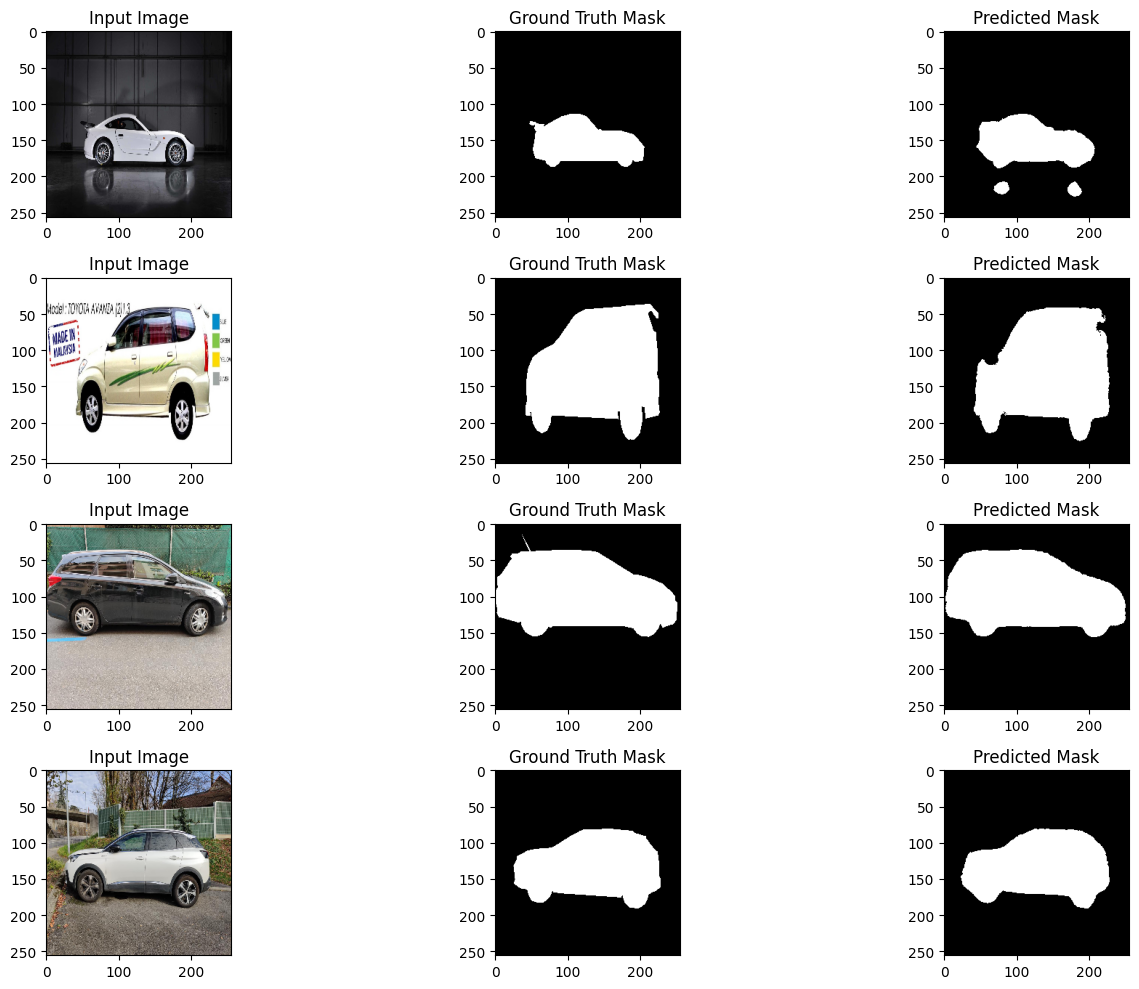

In [ ]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    preds = torch.sigmoid(model(images))
    preds = (preds > 0.5).float()

    fig, axes = plt.subplots(4, 3, figsize=(15, 10))
    for i in range(4):
        axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Денормализация
        axes[i, 0].set_title("Input Image")
        axes[i, 1].imshow(masks[i].cpu().squeeze(0), cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 2].imshow(preds[i].cpu().squeeze(0), cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

**Вывод:** как можем заметить, предиктед маска очень похожа на заданную, но определяется она не без косяков: на белом фоне белые части машин теряются и модель считает их лишними частями, а также отраженные части авто попадают в предсказанную маску

# Часть 2

Ссылка на блокнот со второй частью (гитхаб ругается на слишком большой файл, 2 часть также загружена зипкой): https://colab.research.google.com/drive/1qY3NHlIYc689DBNx-fB9Vgru4YX9gHzQ?usp=sharing